In [1]:
import os
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import PIL
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
#设置显示中文字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams["axes.unicode_minus"] = False

#图像清晰度调整
%config InlineBackend.figure_format = 'retina'

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <08E12B12-6183-307E-BDA0-374FA8EBA2C9> /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <709C1DF5-D253-3C66-87E2-C99FD3A259DF> /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/transformers/ut

In [6]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Encoder 部分（下采样）
        self.encoder1 = self.conv_block(3, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)
        
        # Bottom 部分（最底层）
        self.bottom = self.conv_block(512, 1024)
        
        # Decoder 部分（上采样）
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(128, 64)
        
        # 最后一层，用于输出分割结果
        self.output_conv = nn.Conv2d(64, 1, kernel_size=1)
        
    def conv_block(self, in_channels, out_channels):
        """卷积块：包含两层卷积，每层卷积后跟一个 BatchNorm 和 ReLU 激活"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # 编码器部分
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(nn.MaxPool2d(2)(enc1))
        enc3 = self.encoder3(nn.MaxPool2d(2)(enc2))
        enc4 = self.encoder4(nn.MaxPool2d(2)(enc3))
        
        # Bottom
        bottom = self.bottom(nn.MaxPool2d(2)(enc4))
        
        # 解码器部分 + 跳跃连接
        dec4 = self.upconv4(bottom)
        dec4 = torch.cat((dec4, enc4), dim=1)  # 跳跃连接
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        # 输出层
        output = self.output_conv(dec1)
        output = torch.sigmoid(output)  # 将输出映射到 [0,1] 区间
        return output

# 示例：初始化模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)


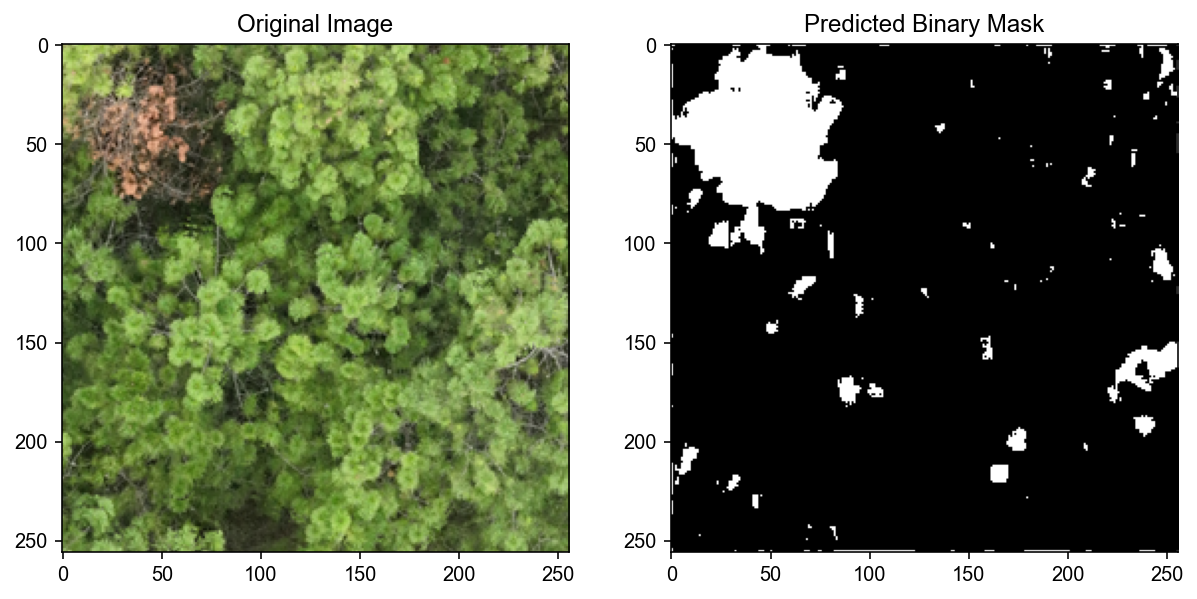

In [11]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

# 加载保存的模型
def load_model(model_path, device):
    model = UNet().to(device)  # 使用之前定义的 SimpleUNet 模型架构
    model.load_state_dict(torch.load(model_path, map_location=device))  # 加载模型权重
    model.eval()  # 设置为评估模式
    return model

# 定义测试函数
def test_model(model, test_image_path, transform, device):
    # 加载测试图像
    image = Image.open(test_image_path).convert('RGB')  # 转换为RGB格式
    original_size = image.size  # 获取原始图像大小
    image = transform(image).unsqueeze(0)  # 应用transform并增加batch维度
    image = image.to(device)

    # 进行预测
    with torch.no_grad():
        output = model(image)
        output = torch.sigmoid(output)  # 使用sigmoid激活函数
        predicted_mask = (output > 0.5).float()  # 将输出转换为二值掩码

        # 调整输出掩码为原始图像的大小
        predicted_mask = F.interpolate(predicted_mask, size=original_size[::-1], mode='bilinear', align_corners=False)
        
        # 确保插值后的掩码也是二值化（再进行一次二值化）
        predicted_mask = (predicted_mask > 0.5).float()

    return predicted_mask

# 可视化测试结果
def visualize_result(image_path, predicted_mask):
    image = Image.open(image_path)
    predicted_mask = predicted_mask.squeeze().cpu().numpy()  # 去掉batch维度并转换为numpy

    # 显示原始图像和预测掩码
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predicted Binary Mask")  # 更正为二值掩码
    plt.show()

# 设置测试参数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = 'UNet1_model.pth'  # 你训练好的模型路径
# test_image_path = '/Users/camus/Desktop/虫害/part.JPG'  # 你的测试图像路径
test_image_path = '/Users/camus/Desktop/trainX/image/image-124.png'  # 你的测试图像路径

# 图像预处理
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# 加载模型
model = load_model(model_path, device)

# 运行测试
predicted_mask = test_model(model, test_image_path, transform, device)

# 可视化结果
visualize_result(test_image_path, predicted_mask)